# 1. Introduction

This work has as objetive make an analysis on the public bids of the Brazilian State Rio Grande do Sul.<br> 
An Anomaly Detection Model is built to identify suspicious items bought on bids.<br>
The datasets contain text and numerical features about the bids description and items bought for the years of 2016 to 2019.<br>
For the analysis, the text features are analyzed for specific recurrent set of words, like items and public organ names, and for numerical features, the item costs.<br>


# 2. Load Packages and Configuration
To Start, load the the required packages (third party and local source) and all configurations (Paths, stopwords, etc.).

In [1]:
%reload_ext autoreload
%autoreload 1
# Load custom local packages
import sys
import os
sys.path.append(os.path.abspath('..'))
# Local Packages
%aimport src.features
from src.features.build_features import build_features
from src.nlp_utils.clean_text import clean_text
from src.nlp_utils.extract_ngrams import extract_ngrams
from src.data.load_data import load_data
from src.data.final_data import build_pred_data
# Standard Packages
import pandas as pd
import numpy as np
from IPython.display import HTML
import gc
import ast
from collections import Counter
# Extras
from datetime import date
import warnings
warnings.filterwarnings('ignore')
# Visualization Packages
import hvplot.pandas
# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
# AutoML
import pycaret.anomaly as pyano
import pycaret.classification as pyclf
# Paths and Config constants
DATA_PATH = os.path.abspath('..')+os.sep+'data'
FIG_PATH = os.path.abspath('..')+os.sep+'reports'+\
            os.sep+'figures'+os.sep
CFG_PATH = os.path.abspath('..')+os.sep+'configs'+os.sep
MODEL_PATH = os.path.abspath('..')+os.sep+'models'
YEARS = [2016, 2017, 2018, 2019]
K_FOLDS = 5
# Load Custom Stopwords
with open(CFG_PATH+'custom_stopwords.txt', 'r') as f:
    CUSTOM_STOPWORDS = list(ast.literal_eval(f.read()))

# 3. Build Required Features
For this task, only a few features are needed to explore the data and build the anomaly detector.<br>
The datasets are big, so it's useful to reduce their file size. Only `licitacao.csv` and `item.csv` are used. Some features are extracted for the processed datasets and saved as parquet. <br>
Only bought items (`TP_OBJETO` equals `COM`) are saved for the Bid Features.

In [2]:
bid_features = ['NR_LICITACAO', 'CD_ORGAO', 'NM_ORGAO', 'DS_OBJETO',
                 'TP_OBJETO', 'ANO_LICITACAO']
item_features = ['NR_LICITACAO', 'CD_ORGAO', 'DS_ITEM', 'VL_UNITARIO_HOMOLOGADO']

build_features(dataset='licitacao', data_path=DATA_PATH, cols=bid_features, values=YEARS)
print('=' * 18)
build_features(dataset='item', data_path=DATA_PATH, cols=item_features, values=YEARS)

Building Features for licitacao...
Saving extracted features to parquet file...
Building features process finished!
Building Features for item...
Saving extracted features to parquet file...
Building features process finished!


# 4. Load Processed Data
As the processed data is built, let's load and get some information about them.<br>
There are two datasets: Bids (For Bidding process) and Items (For Items Description and Prices).<br>
Both datasets have the Public Organs names and codes.

In [3]:
bid, item = load_data(data_path=DATA_PATH, years=YEARS)

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,DS_OBJETO
0,84100,PM DE ESPERANÇA DO SUL,4.0,2016,Aquisição de merenda escolar
1,82701,CM DE XANGRI-LÁ,1.0,2016,AQUISIÇÃO DE PROTOCOLADORA E FRAGMENTADORA DE ...
2,84100,PM DE ESPERANÇA DO SUL,6.0,2016,Aquisição de materiais de limpeza para as dive...


Number of samples: 82190
 


,CD_ORGAO,NR_LICITACAO,DS_ITEM,VL_UNITARIO_HOMOLOGADO,ANO_LICITACAO
0,77200,15.0,"Pneu 1000/20 liso radial, dianteiro, 16 lonas,...",1430.0,2016
1,77200,15.0,"Pneu 12.4x24 garra baixa, 10 lonas",1258.0,2016
2,77200,15.0,Pneu 1400x24 mínimo 12 lonas,1998.0,2016


Number of samples: 3079700
 
There are no problems with Code and Organ names.
 
There are 843 Public Organs in the Dataset.


The Item dataset is so much bigger than the bids dataset, maybe, for more demanding task, a subset could be needed.<br>
Time to check about the missing values.

In [4]:
display(HTML('<b>Missing values for Bids'), bid.isnull().sum())
print(' ')
display(HTML('<b>Missing values for Items'), item.isnull().sum())

CD_ORGAO         0
NM_ORGAO         0
NR_LICITACAO     0
ANO_LICITACAO    0
DS_OBJETO        0
dtype: int64

CD_ORGAO                       0
NR_LICITACAO                   0
DS_ITEM                        1
VL_UNITARIO_HOMOLOGADO    604785
ANO_LICITACAO                  0
dtype: int64

There are a lot of missing values on `VL_UNITARIO_HOMOLOGADO` (Item Prices) for the Items dataset and just one for `DS_ITEM` (Items Price).<br>
I will mantain these values for the Exploratory Data Analysis and drop later for the Anamoly Detection Model. 

# 5. Exploratory Data Analysis
This section is divided in two parts: A first for all data and a second with filtered data, with only the Public Organs that had more costs on buying items.
# 5.1 General Analysis
Let's start showing the total bids progression through the years, on the Figure 1.

In [5]:
sf = bid['ANO_LICITACAO'].value_counts()
df = pd.DataFrame({'Year': sf.index,
                    'Total': sf.values})
df.sort_values(by=['Year'], inplace=True)

fig = df.hvplot.line(x='Year', y=['Total'], grid=True,
                xticks=np.arange(2016, 2019.5, 1).tolist(),
                title='Figure 1 - Total Bids by Year (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-1.png')
fig

:Curve   [Year]   (Total)

From 2016 to 2017, was a big growth on the number of biddings, with a small growth for 2018 and a small decrease for 2019, but with a total close to 2017. <br>
Let's do the same chart, but now for the total costs, as shown on Figure 2.

In [6]:
df = item.groupby(['ANO_LICITACAO']).sum('VL_UNITARIO_HOMOLOGADO').\
    drop(['NR_LICITACAO'], axis=1).reset_index().sort_values(by=['ANO_LICITACAO'])

fig = df.hvplot.line(x='ANO_LICITACAO', y=['VL_UNITARIO_HOMOLOGADO'], grid=True,
                xticks=np.arange(2016, 2019.5, 1).tolist(), yformatter='%.1d',
                xlabel='Year', ylabel='Total',
                title='Figure 2 - Total Bid Costs by Year (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-2.png')
fig

:Curve   [ANO_LICITACAO]   (VL_UNITARIO_HOMOLOGADO)

So, even with the big leap on the total number of bids from 2016 to 2017, the total costs are low, but was a huge increase from 2017 to 2018 and a decrease for 2019, following the same behavior for the total number of biddings.<br>
And about the Public Organs with most bids? Let's see it on the Figure 3.

In [7]:
top_n = 5
sf = bid['NM_ORGAO'].value_counts().head(top_n)
# Wil be used later
sf_cd = bid['CD_ORGAO'].value_counts().head(top_n)
top10_cd = sf_cd.index.tolist()
df = pd.DataFrame({'Public Organ': sf.index,
                    'Total': sf.values})

fig = df.hvplot.barh(x='Public Organ', y='Total', flip_yaxis=True, width=900,
                    xticks=np.arange(0, 2000, 300).tolist(), grid=True,
                    title='Figure 3 - Top 5 Public Organs by Number of Bids (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-3.png')
fig
                

:Bars   [Public Organ]   (Total)

On the results, PM DE GUAPORÉ has a high number of bids, more than CENTRAL DE LICITAÇÕES DO ESTADO. It's also important to note the the PM Organs (Military Police) appear three times on the Figure 3.<br>
Now, let's analyze this for Top 5 (and from now on, I will work with Top 5) the bids costs on the Figure 4.

In [8]:
sf = item.groupby(['CD_ORGAO']).sum('VL_UNITARIO_HOMOLOGADO').\
    drop(['NR_LICITACAO'], axis=1).reset_index().\
    sort_values(by=['VL_UNITARIO_HOMOLOGADO'],
                ascending=False).head(top_n)

cdo_list = sf['CD_ORGAO'].tolist()
po_names = []

for cdo in cdo_list: 
    po_list = bid.query('CD_ORGAO == @cdo')
    po_name = po_list['NM_ORGAO'].unique()
    po_names.append(po_name[0])

df = pd.DataFrame({'Public Organ': po_names,
                    'Total': sf['VL_UNITARIO_HOMOLOGADO']})

fig = df.hvplot.barh(x='Public Organ', y='Total', flip_yaxis=True,
                    grid=True, xformatter='%.1d', width=950,
                    title=f'Figure 4 - Top {top_n} Public Organs by Total Value of Bids (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-4.png')
fig

:Bars   [Public Organ]   (Total)

The only one Public Organ that appears on Figures 3 and 4 is CENTRAL DE LICITAÇÕES DO ESTADO, what is logical, because it is the main organ to make bids.<br>
Another Military Organ appears here, PM DE PORTO ALEGRE.<br>
There are two sewage companies on the most costly bids: CIA. RIOGRANDENSE DE SANEAMENTO e CONS. PÚBL. SAN. BÁSICO DA BACIA HIDROG. DO RIO DOS SINOS.<br>
Let's see how is the distribution of costs by these companies, as shown om the Figure 5.

In [9]:
po_top_costs = item.query('CD_ORGAO in(@cdo_list)')
top_dict = dict(zip(cdo_list, po_names))
# Top costs organs
po_top_costs['NOME_ORGAO'] = po_top_costs['CD_ORGAO'].map(top_dict)

fig = po_top_costs.hvplot.box(y='VL_UNITARIO_HOMOLOGADO', by='NOME_ORGAO',
                                width=1050, invert=True, xformatter='%.1d',
                                xlabel='Public Organ', ylabel='Cost Distribution',
                                title='Figure 5 - Item Costs Distribution from most costly Public Organs (2016-2019)')
hvplot.save(fig, FIG_PATH+'fig-5.png')
fig

:BoxWhisker   [NOME_ORGAO]   (VL_UNITARIO_HOMOLOGADO)

There are a good number of outliers and a similar distribution between for of them (except CONS. PÚBL. SAN. BÁSICO DA BACIA HIDROG. DO RIO DOS SINOS). I have the idea for the anomaly detector after see this chart.<br>
Remember about the missing values on Items `VL_UNITARIO_HOMOLOGADO`? Let's check what Public Organs are on it on the Figure 6.

In [10]:
item_missing = item[item['VL_UNITARIO_HOMOLOGADO'].isnull()]
top_missing = item['CD_ORGAO'].value_counts().head(top_n)

df = pd.DataFrame({'Public Organ': top_missing.index,
                    'Total': top_missing.values})

df_list = df['Public Organ'].tolist()
df_names = []

for cdo in df_list: 
    p_list = bid.query('CD_ORGAO == @cdo')
    df_name = p_list['NM_ORGAO'].unique()
    df_names.append(df_name[0])

df['Public Organ'] = df_names

fig = df.hvplot.barh(x='Public Organ', y='Total', flip_yaxis=True,
                    grid=True, xformatter='%.1d', width=900,
                    title=f'Figure 6 - Top {top_n} Public Organs by Item Cost Missing Values (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-6.png')
fig

:Bars   [Public Organ]   (Total)

And all presented Public Organs on Figure 6 are Military Police.

# 5.2 Analysis on Top 5 most costly Public Organs
To work the text features, I will only work with a subset (The Top 5 on the bid costs, from Figure 4). I take this decision because my hardware cannot handle this large data.<br>
Also, I need to make pre-processing on text features, the initial idea was use Spacy to get NER features, but my hardware was unable to handle it, so I changed to bi-gram extraction usinh NLTK.<br>
Let's start the pre-processing on the text cleaning it (lowering, remove stopwords and accents, replacing mispelled words, etc.)

In [11]:
po_top_costs_bid = bid.query('CD_ORGAO in(@cdo_list)')
bid_top = clean_text(df=po_top_costs_bid, feature='DS_OBJETO', 
                    custom_stop=CUSTOM_STOPWORDS)
item_top = clean_text(df=po_top_costs, feature='DS_ITEM', 
                    custom_stop=CUSTOM_STOPWORDS)
gc.collect()
# Some mispelled words to replace on Bids
dict_miss_bids = []
with open(CFG_PATH+'mispelled_words_bids.txt','r') as inf:
    dict_miss_bids = eval(inf.read())
# Some mispelled words to replace on Items
dict_miss_items = []
with open(CFG_PATH+'mispelled_words_items.txt','r') as inf:
    dict_miss_items = eval(inf.read())
# Replace the mispelled words    
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].replace(dict_miss_bids, regex=True)
item_top['DS_ITEM'] = item_top['DS_ITEM'].replace(dict_miss_items, regex=True)
# Delete variables to free memory
del bid, item, po_top_costs, po_top_costs_bid, df, sf

As the process finished, let's see the most bought items and services based on the bi-grams from `DS_ITEM` presented in Items dataset, as show the Figure 7.

In [12]:
# Extract n-grams
top_n_grams = extract_ngrams(corpus=item_top['DS_ITEM'],
                                n=2, top_n=10) 
n_gram, total = map(list,zip(*top_n_grams))

df = pd.DataFrame({'Items' : n_gram,
                    'Total' : total})

fig = df.hvplot.barh(x='Items', y='Total', flip_yaxis=True, width=900,
                    title='Figure 7 - Top 10 Items and Services by Mostly Costly Public Organs (2016-219)')
hvplot.save(fig, FIG_PATH+'fig-7.png')
fig

:Bars   [Items]   (Total)

On the chart, `fio cirurgico` (surgical thread) was the most buyed item. Housing Items had a constant appearance on this too, also is important to note that items related to sewage companies, `grupo motorbomba` and `motorbomba submersa`, appear on the positions 2nd and 3r, respectively.
Now, let's see the bid types from `DS_OBJETO` in Bids Dataset, on the Figure 8.

In [13]:

top_n_grams = extract_ngrams(corpus=bid_top['DS_OBJETO'],
                                n=2, top_n=10)
n_gram, total = map(list,zip(*top_n_grams))

df = pd.DataFrame({'Description' : n_gram,
                    'Total' : total})

fig = df.hvplot.barh(x='Description', y='Total', flip_yaxis=True, width=900,
                    title='Figure 8 - Top 10 Bid Types by Mostly Costly Public Organs (2016-219)')
hvplot.save(fig, FIG_PATH+'fig-8.png')
fig

:Bars   [Description]   (Total)

Medical Items (`equipamentos hospitalares`) and Informatic Items (equipamentos Informatica) are the leaders here (1st and 2nd), followed food products (`alimentacao produtos`). 

# 6. Anomaly Detection Model
In this section, the Anomaly Model is built, as well a model to classify the anomalies.
# 6.1 Model 
To create the anomaly model, the pre-processed text features are joined and will be used with `VL_UNITARIO_HOMOLOGADO`, creating a new dataset with these two features. The Datasets are inner joined on `NR_LICITACAO` feature.

In [14]:
data = build_pred_data(item_top, bid_top, YEARS)
del item_top, bid_top
data['TEXT'] = data.DS_OBJETO+' '+data.DS_ITEM
data.drop(['DS_ITEM', 'DS_OBJETO'], axis=1, inplace=True)
data.head(3)

,VL_UNITARIO_HOMOLOGADO,TEXT
0,159.50,cola contato cola contato tolueno lata
1,0.84,medicamentos humanos aminofilina injetavel
2,4.50,medicamentos humanos hidroxido aluminio suspensao


To work with the text feature, a TF_IDF process is made to convert it to numerical features.

In [15]:
tfidf_vec= TfidfVectorizer(min_df=.02, max_df=.7, ngram_range=[1,2])

t_tfidf = tfidf_vec.fit_transform(data['TEXT'])
data_tfidf = pd.DataFrame(t_tfidf.toarray(), 
                          columns=tfidf_vec.get_feature_names(), 
                          index=data.index)

data = pd.concat([data_tfidf, data['VL_UNITARIO_HOMOLOGADO']], axis=1)
data.head(3)

,acessorios,agua,alcool,alimentacao,alimentacao produtos,cabo,cirurgico,construcao,consumo,consumo hospitalar,...,manutencao,material,medicamentos,pereciveis,produtos,produtos pereciveis,pvc,seguranca,tubo,VL_UNITARIO_HOMOLOGADO
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.50
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.84
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.50


And now, identify the outliers using the iforest algorithm.

In [16]:
exp_ano = pyano.setup(data=data, silent=True, session_id=42)
model = pyano.create_model('iforest')
data_ano = pyano.assign_model(model)
data_ano.drop(['Score'], axis=1, inplace=True)
display(data_ano.head(3))
print('Detected Anomalies')
data_ano['Label'].value_counts()

,acessorios,agua,alcool,alimentacao,alimentacao produtos,cabo,cirurgico,construcao,consumo,consumo hospitalar,...,material,medicamentos,pereciveis,produtos,produtos pereciveis,pvc,seguranca,tubo,VL_UNITARIO_HOMOLOGADO,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.50,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.84,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.50,0


Detected Anomalies


0    51697
1     2719
Name: Label, dtype: int64

And 2708 samples were detected as anomalies by the iforest algorithm.

# 6.2 Classification Model
The model building on this project is automatized with Pycaret, it can make feature engineering and split data. By default, it uses 70% of data for train and 30% for test.<br>
No data imbalance method is used, as the idea is classify anamolies, what as principle should be rare.

In [17]:
exp_clf = pyclf.setup(data=data_ano,
                     target='Label',
                     silent=True,
                     log_experiment=True,
                     session_id=42,
                     experiment_name='Anomaly Classification')

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(54416, 33)"
4,Missing Values,False
5,Numeric Features,32
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Let's compare all models on Pycaret (except models with large train time, as CatBoost and MLP) and get the model with the best F1-Score, as the data is imbalanced.<br>
All compared models are score using cross validation for 5-folds.

In [18]:
top_model = pyclf.compare_models(exclude=['catboost'],
                                fold=K_FOLDS,
                                sort='F1',
                                n_select=1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.9987,0.9999,0.9800,0.9936,0.9868,0.9861,0.9861,5.1378
1,Light Gradient Boosting Machine,0.9987,0.9998,0.9784,0.9947,0.9865,0.9858,0.9858,1.4639
2,Extra Trees Classifier,0.9985,0.9984,0.9753,0.9936,0.9843,0.9835,0.9836,2.9180
3,Random Forest Classifier,0.9982,0.9968,0.9669,0.9973,0.9818,0.9809,0.9810,0.3320
4,Decision Tree Classifier,0.9981,0.9893,0.9795,0.9832,0.9813,0.9803,0.9803,0.2274
5,Gradient Boosting Classifier,0.9980,0.9996,0.9695,0.9893,0.9793,0.9782,0.9783,8.4616
6,Ada Boost Classifier,0.9968,0.9989,0.9443,0.9912,0.9671,0.9654,0.9658,3.4305
7,Ridge Classifier,0.9827,0.0000,0.8497,0.8130,0.8305,0.8214,0.8219,0.1120
8,Linear Discriminant Analysis,0.9826,0.9911,0.8502,0.8118,0.8302,0.8211,0.8215,0.6232
9,Quadratic Discriminant Analysis,0.9722,0.9844,0.9296,0.6713,0.7751,0.7610,0.7749,0.2414


And tune this model (Extreme Gradient Boosting, also called XGBoost) with GridsearchCV for 5-foldes to get better results.

In [19]:
best_model = pyclf.tune_model(estimator=top_model, fold=K_FOLDS,
                              optimize="F1", choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9992,1.0000,0.9895,0.9947,0.9921,0.9917,0.9917
1,0.9984,0.9999,0.9711,0.9973,0.9840,0.9832,0.9833
2,0.9986,0.9997,0.9737,0.9973,0.9854,0.9846,0.9847
3,0.9988,0.9998,0.9816,0.9947,0.9881,0.9875,0.9875
4,0.9986,0.9999,0.9816,0.9894,0.9855,0.9847,0.9848
Mean,0.9987,0.9998,0.9795,0.9947,0.9870,0.9863,0.9864
SD,0.0003,0.0001,0.0065,0.0029,0.0029,0.0030,0.0030


As the tuned model was better in the F1-Score than the base model, the function returned the tuned model as the best model.

# 6.3 Test Results
Let's predict the test data and plot the confusion matrix.

In [20]:
pyclf.predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9984,0.9999,0.9706,0.9975,0.9839,0.983,0.9831


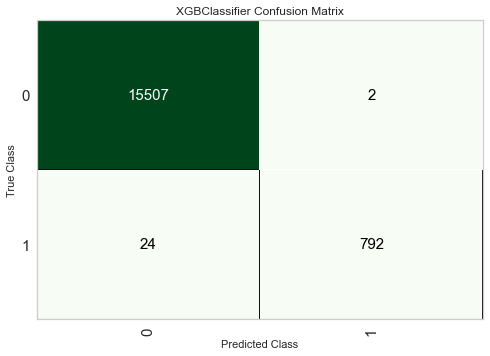

In [21]:
pyclf.plot_model(best_model, plot="confusion_matrix")

The F1-Score for the test set was very good, near 0.98 with a few error on the Confusion Matrix. <br>
Let's see the Features Importance.

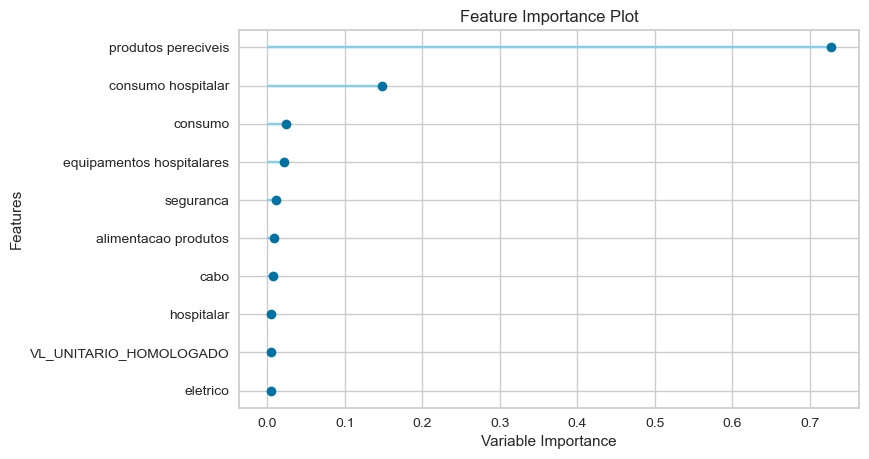

In [22]:
pyclf.plot_model(best_model, plot='feature')

The feature`produtos pereciveis` has a great impact on the predictions results, followed by `consumo hospitalar`.<br> 
Let's check the metrics of each class.

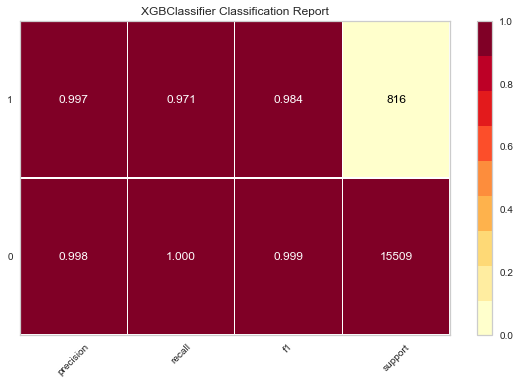

In [23]:
pyclf.plot_model(best_model, plot='class_report')

And all results are around 0.99, which is good for the metrics in each class.<br>
Now, just save the model.

In [24]:
pyclf.save_model(best_model, MODEL_PATH+os.sep+"modelXGB_"+date.today().strftime("%m-%d-%Y"))

Transformation Pipeline and Model Succesfully Saved


# 7. Conclusion

From the collected analysis and results, it's possible to take the following conclusions:

- There was a huge incresase on bid costs from 2017 to 2018.
- Military Police Organs have a good amount on Public Bids solicitations.
- Sewage Organs are a quite present on Public Bids costs from 2016 to 2019.
- There are some costs beyond the normal bid buys for the 5 most costly public organs.
- Military Police Organs have a huge amount on missing prices for public bid items.
- Sewage equipments are present on the most bought items.
- Medical and Informatic are the most recurrent items on the public bids descriptions.
- It was possible to detect anomalies using the iforest algorithm with the TF-IDF and Item Price Features.
- The Classification Model was able to get a good score, around 0.98 on F1-Score for the test set, on detecting anomalies, using XGBoost algorithm.
- The Food item `produtos pereciveis` has a huge impact on the model prediction.  

For future works consider the following:
- Analyze the occurence of the items with 0.0 cost in the Items dataset
- Identify Items using NER.
- Evalute features by reason (shap).